In [4]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.ticker import NullLocator
import matplotlib.lines as mlines
%matplotlib inline
from matplotlib import pyplot as plt
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir = "../../figures/SI/biases"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
sc._settings.figdir = output_dir
output_suffix = ""
output_formats = [".png",".pdf"]
def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

plt.style.use('../../scripts/bursa.mplstyle')

In [5]:
%run ../../scripts/helper.py

In [6]:
data = pd.read_table("../../../data/gex/bcells.obs.tsv.gz")
data = data[data.probable_hq_single_b_cell == True]
data.loc[:,"locus"] = data.locus.fillna("Not Detected")
data.loc[:,"detected"] = data.locus.map({"IGH": "Detected", "Not Detected": "Not Detected"})
data.loc[:,"bcelltype"] = data.celltypist
all_cells = pd.read_table("../../../data/gex/all_cells.obs.tsv.gz")

/tmp/ipykernel_37646/1354146652.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_table("../../../data/gex/bcells.obs.tsv.gz")
/tmp/ipykernel_37646/1354146652.py:6: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  all_cells = pd.read_table("../../../data/gex/all_cells.obs.tsv.gz")


In [7]:
data['HT_library'] = data['sample_uid'].str.contains("HT")
data['data_from_this_study'] = data.sample_uid.str.contains('TBd')
data['frozen'] = data.sample_uid.str.contains('frozen')

# pre-process / calculate statistics

In [8]:
# Grouping data by specific columns and normalizing the value counts
plot_data = all_cells[all_cells.donor.str.contains('TBd')].groupby(['tissue', 'sample_uid'])['possible_b_cell'].value_counts(normalize=True)

# Filtering data
plot_data = plot_data[plot_data > 0]
plot_data = plot_data.reset_index()
plot_data = plot_data[plot_data['possible_b_cell'] == True]
plot_data['negative_selection'] = ~plot_data['tissue'].str.contains("LN")
plot_data['negative_selection'] = ~plot_data['sample_uid'].str.contains("TBd5_frozen_PB") & plot_data['negative_selection']

# Renaming columns
plot_data = plot_data.rename(columns={'negative_selection': 'negative \nselection'})


In [9]:
## VDJ conditioning bias

# Calculate naive proportions
naive_df = data.groupby(['sample_uid', 'tissue', 'bcelltype']).size().reset_index(name='Naive_Count')
total_count = naive_df.groupby(['sample_uid', 'tissue']).Naive_Count.transform('sum')
naive_df['Naive_Proportion'] = naive_df['Naive_Count'] / total_count

# Calculate proportions conditioned on "Detected"
conditioned_df = data[data['detected'] == 'Detected'].groupby(['sample_uid', 'tissue', 'bcelltype']).size().reset_index(name='Conditioned_Count')
total_conditioned_count = conditioned_df.groupby(['sample_uid', 'tissue']).Conditioned_Count.transform('sum')
conditioned_df['Conditioned_Proportion'] = conditioned_df['Conditioned_Count'] / total_conditioned_count

# Merge the two DataFrames to compare proportions
# You'll need to determine the appropriate columns for merging based on your specific needs
merged_df = pd.merge(naive_df, conditioned_df, how='left', left_on=['sample_uid', 'tissue', 'bcelltype'], right_on=['sample_uid','tissue', 'bcelltype'])

# Calculate the difference between the two sets of proportions
merged_df['Proportion_Difference'] = merged_df['Naive_Proportion'] - merged_df['Conditioned_Proportion']

# Now, merged_df contains both the naive and conditioned proportions, as well as their differences


# Generate Plot

/tmp/ipykernel_37646/942002329.py:30: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=long_df, x='Proportion', y='bcelltype', hue='Condition',


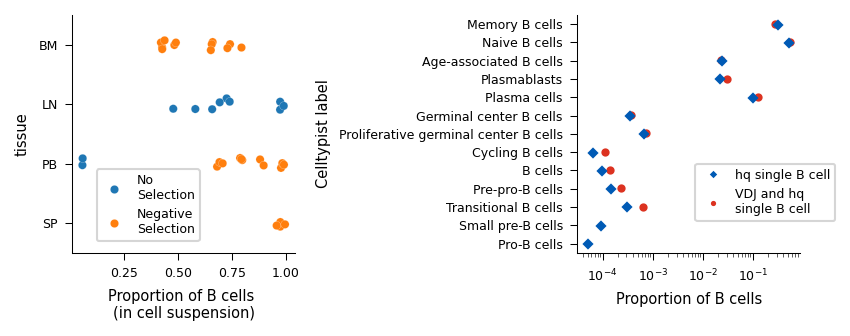

In [10]:
# Melt the DataFrame to long format
color1 = '#005AB5'
color2 = '#DC3220'
long_df = pd.melt(merged_df, id_vars=['sample_uid', 'tissue', 'bcelltype'], 
                  value_vars=['Naive_Proportion', 'Conditioned_Proportion'], 
                  var_name='Condition', value_name='Proportion')
order = data.bcelltype.unique()
# Sort cell types based on the order in the original df
long_df['bcelltype'] = pd.Categorical(long_df['bcelltype'], categories=order, ordered=True)
long_df = long_df.sort_values('bcelltype')
## B Cell Purification

# Create a single figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(6, 2.25), tight_layout = True)
fig.subplots_adjust(wspace=3.5)  # Adjust this value to increase/decrease space between subplots

# Second plot (now on the left)
sns.stripplot(data=plot_data, y='tissue', hue='negative \nselection', x='proportion', size=4, edgecolor='white', linewidth=0.1, palette='tab10', ax=axes[0])

# Legend and other settings for the second plot (now on the left)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ["No\nSelection", "Negative\nSelection"], title=None, loc='right', bbox_to_anchor=(0.6, 0.2))
axes[0].xaxis.set_minor_locator(NullLocator())
axes[0].set_xlabel("Proportion of B cells \n(in cell suspension)")
axes[0].set_ylabel("tissue")
axes[0].set_xscale("linear")
sns.despine(ax=axes[0])

# First plot (now on the right)
sns.pointplot(data=long_df, x='Proportion', y='bcelltype', hue='Condition',
              ax=axes[1], markers=['o', 'D'], scale = 0.8,
              palette={'Naive_Proportion': color1, 'Conditioned_Proportion': color2}, linestyle="", dodge=True, errorbar=None)

# Legend and other settings for the first plot (now on the right)
red_line = mlines.Line2D([], [], color=color1, marker='D', markersize=1.5, label='hq single B cell', linestyle='None')
black_line = mlines.Line2D([], [], color=color2, marker='o', markersize=1.5, label='VDJ and hq\nsingle B cell', linestyle='None')
axes[1].legend(handles=[red_line, black_line], bbox_to_anchor=(0.5, 0.4))
axes[1].set_xscale('log')
axes[1].set_xlabel('Proportion of B cells')
axes[1].set_ylabel('Celltypist label')
axes[1].yaxis.set_minor_locator(NullLocator())
sns.despine(ax=axes[1])

# Show the plot
plt.tight_layout()
plt.show()
